### Carga de librerías

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, classification_report, mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.utils import resample
import graphviz # Importar el visualizador del árbol.

## Selección de los datos
---
### Carga de los datos

Los datos los hemos obtenido realizando encuestas a los miembros del gimnasio, tanto para los que han abandonado como los que siguen en el gimnasio.

In [ ]:
data = pd.read_excel('datos_gimnasio_completo.xlsx')
data.head()

,ID Cliente,Edad,Sexo,Tipo de membresía,Asistencias/mes,Antigüedad (meses),Usa clases dirigidas,Usa app,Abandonó,Peso (kg),Altura (cm),Objetivo principal,Participa en retos,Satisfacción (0-10),Comentarios negativos,Recibió oferta especial,Motivo de abandono
0,1,39,F,Premium,8,28,No,Sí,Sí,85.1,155,Ganar masa muscular,No,1,Sí,No,Insatisfacción
1,2,33,F,Básica,25,11,Sí,Sí,No,98.8,180,Ganar masa muscular,No,7,No,Sí,NaN
2,3,41,M,Premium,4,33,Sí,Sí,No,66.9,170,Perder peso,No,2,No,No,NaN
3,4,50,F,Premium,3,17,No,No,No,82.6,183,Otro,No,2,Sí,Sí,NaN
4,5,32,M,Básica,6,6,Sí,Sí,No,84.2,167,Mejorar salud,Sí,5,Sí,Sí,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID Cliente               200 non-null    int64  
 1   Edad                     200 non-null    int64  
 2   Sexo                     200 non-null    object 
 3   Tipo de membresía        200 non-null    object 
 4   Asistencias/mes          200 non-null    int64  
 5   Antigüedad (meses)       200 non-null    int64  
 6   Usa clases dirigidas     200 non-null    object 
 7   Usa app                  200 non-null    object 
 8   Abandonó                 200 non-null    object 
 9   Peso (kg)                200 non-null    float64
 10  Altura (cm)              200 non-null    int64  
 11  Objetivo principal       200 non-null    object 
 12  Participa en retos       200 non-null    object 
 13  Satisfacción (0-10)      200 non-null    int64  
 14  Comentarios negativos    2

Dado que la matriz de correlación nos indica que no existen relaciones destacables entre ninguna columna, no podemos eliminar a ninguna basándonos en este criterio. Solo quitamos la columna ID debido a que no aporta nada al resto de las demás ni se correlaciona en nada con las mismas. También quitamos la columna de si recibió una oferta especial el cliente.


In [ ]:
data = data.drop('ID Cliente', axis=1)
data = data.drop('Recibió oferta especial', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Edad                   200 non-null    int64  
 1   Sexo                   200 non-null    object 
 2   Tipo de membresía      200 non-null    object 
 3   Asistencias/mes        200 non-null    int64  
 4   Antigüedad (meses)     200 non-null    int64  
 5   Usa clases dirigidas   200 non-null    object 
 6   Usa app                200 non-null    object 
 7   Abandonó               200 non-null    object 
 8   Peso (kg)              200 non-null    float64
 9   Altura (cm)            200 non-null    int64  
 10  Objetivo principal     200 non-null    object 
 11  Participa en retos     200 non-null    object 
 12  Satisfacción (0-10)    200 non-null    int64  
 13  Comentarios negativos  200 non-null    object 
 14  Motivo de abandono     60 non-null     object 
dtypes: flo

Como queremos analizar sobre todo los motivos por los que los clientes abandonan, hacemos una gráfica circular que nos oriente sobre la situación actual.

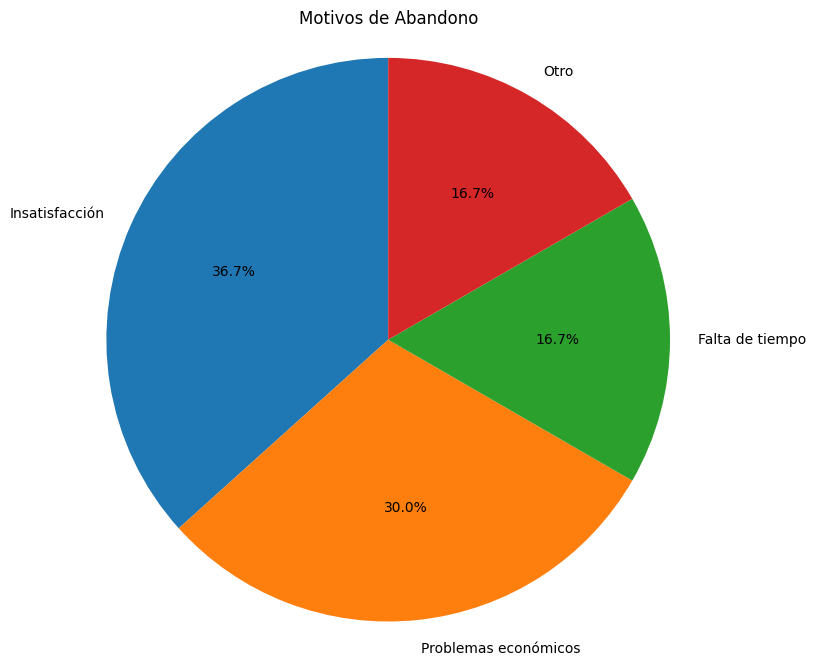

In [ ]:
# Cuenta la frecuencia de cada motivo de abandono
motivos_abandono = data['Motivo de abandono'].value_counts()

# Crea el diagrama circular
plt.figure(figsize=(8, 8))
plt.pie(motivos_abandono, labels=motivos_abandono.index, autopct='%1.1f%%', startangle=90)
plt.title('Motivos de Abandono')
plt.axis('equal')  # Asegura que el círculo sea proporcional
plt.show()


Vemos que los resultados de los valores que no son nulos reflejan los siguinete:

* El 36.7% abandonan por insatisfacción.
* El 30.0% abandonan por problemas económicos.
* El 16.7% abandonan por falta de tiempo.
* El 16.7% restante abandonan por otro motivo.

## Preprocesamiento
---
### Valores faltantes
Para el campo motivo de abandono se imputa el valor “no abandono” sobre los missing values de dicha columna, ya que representa a las personas que no han abandonado.

In [ ]:
data['Motivo de abandono'] = data['Motivo de abandono'].fillna('no abandono')
data.head()

,Edad,Sexo,Tipo de membresía,Asistencias/mes,Antigüedad (meses),Usa clases dirigidas,Usa app,Abandonó,Peso (kg),Altura (cm),Objetivo principal,Participa en retos,Satisfacción (0-10),Comentarios negativos,Motivo de abandono
0,39,F,Premium,8,28,No,Sí,Sí,85.1,155,Ganar masa muscular,No,1,Sí,Insatisfacción
1,33,F,Básica,25,11,Sí,Sí,No,98.8,180,Ganar masa muscular,No,7,No,no abandono
2,41,M,Premium,4,33,Sí,Sí,No,66.9,170,Perder peso,No,2,No,no abandono
3,50,F,Premium,3,17,No,No,No,82.6,183,Otro,No,2,Sí,no abandono
4,32,M,Básica,6,6,Sí,Sí,No,84.2,167,Mejorar salud,Sí,5,Sí,no abandono


Reacemos el gráfico.

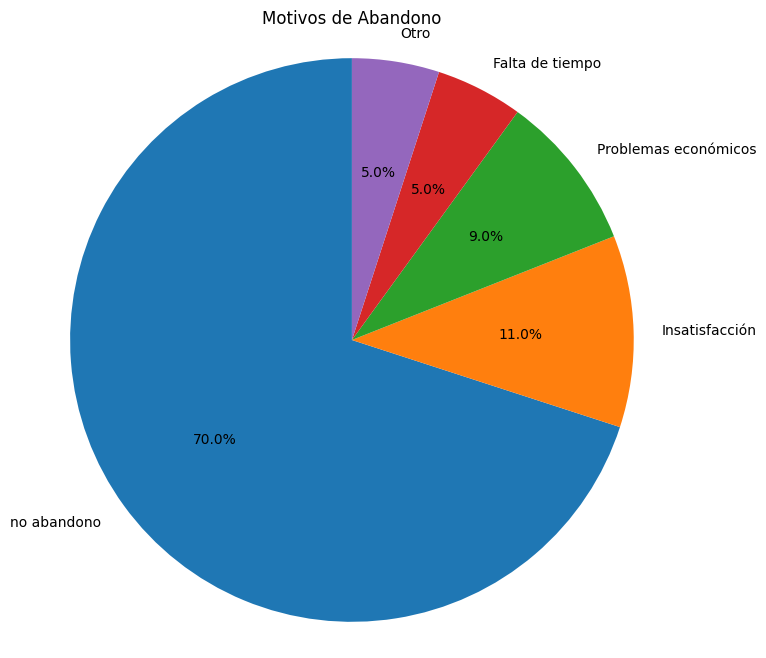

In [ ]:
motivos_abandono = data['Motivo de abandono'].value_counts()

# Crea el diagrama circular
plt.figure(figsize=(8, 8))
plt.pie(motivos_abandono, labels=motivos_abandono.index, autopct='%1.1f%%', startangle=90)
plt.title('Motivos de Abandono')
plt.axis('equal')  # Asegura que el círculo sea proporcional
plt.show()

Ahora, con la nueva etiqueta de "no abandono" obtenemos la siguiente información:

* El 70% de los clientes no abandona el gimnasio.
* El 30% de los clientes abandona el gimnasio. De los cuales:
  * El 11% abandonan por insatisfacción.
  * El 9% abandonan por problemas económicos.
  * El 5% abandonan por falta de tiempo.
  * El 5% restante abandonan por otro motivo.

La media de edad de las personas que ha abandonado es de 35 años.

In [ ]:
average_age_abandon = data[data['Motivo de abandono'] != 'no abandono']['Edad'].mean()

print(f"La media de personas que abandono es de {round(average_age_abandon)} años")


La media de personas que abandono es de 35 años


### Pasando nuestros datos a numéricos
Una serie de variables contienen valores cómo “Sí”/”No”. Podemos cambiarlo a valores como 0 y 1 (booleano) para ayudar al modelo.

In [ ]:
data['Usa clases dirigidas'] = data['Usa clases dirigidas'].map({'Sí': 1, 'No': 0})
data['Usa app'] = data['Usa app'].map({'Sí': 1, 'No': 0})
data['Abandonó'] = data['Abandonó'].map({'Sí': 1, 'No': 0})
data['Participa en retos'] = data['Participa en retos'].map({'Sí': 1, 'No': 0})
data['Comentarios negativos'] = data['Comentarios negativos'].map({'Sí': 1, 'No': 0})
data.head()

,Edad,Sexo,Tipo de membresía,Asistencias/mes,Antigüedad (meses),Usa clases dirigidas,Usa app,Abandonó,Peso (kg),Altura (cm),Objetivo principal,Participa en retos,Satisfacción (0-10),Comentarios negativos,Motivo de abandono
0,39,F,Premium,8,28,0,1,1,85.1,155,Ganar masa muscular,0,1,1,Insatisfacción
1,33,F,Básica,25,11,1,1,0,98.8,180,Ganar masa muscular,0,7,0,no abandono
2,41,M,Premium,4,33,1,1,0,66.9,170,Perder peso,0,2,0,no abandono
3,50,F,Premium,3,17,0,0,0,82.6,183,Otro,0,2,1,no abandono
4,32,M,Básica,6,6,1,1,0,84.2,167,Mejorar salud,1,5,1,no abandono


Ahora imputaremos las distintas columnas categóricas en valores numéricos.

In [ ]:
data['Sexo'] = data['Sexo'].map({'M': 0, 'F': 1})
data['Tipo de membresía'] = data['Tipo de membresía'].map({'Básica': 0, 'Estándar': 1, 'Premium': 2})
data['Motivo de abandono'] = data['Motivo de abandono'].map({'no abandono': 0, 'Insatisfacción': 1, 'Problemas económicos': 2, 'Falta de tiempo': 3, 'Otro': 4})
data['Objetivo principal'] = data['Objetivo principal'].map({'Ganar masa muscular': 0, 'Mejorar salud': 1, 'Perder peso': 2, 'Otro': 3})

data.head()

,Edad,Sexo,Tipo de membresía,Asistencias/mes,Antigüedad (meses),Usa clases dirigidas,Usa app,Abandonó,Peso (kg),Altura (cm),Objetivo principal,Participa en retos,Satisfacción (0-10),Comentarios negativos,Motivo de abandono
0,39,1,2,8,28,0,1,1,85.1,155,0,0,1,1,1
1,33,1,0,25,11,1,1,0,98.8,180,0,0,7,0,0
2,41,0,2,4,33,1,1,0,66.9,170,2,0,2,0,0
3,50,1,2,3,17,0,0,0,82.6,183,3,0,2,1,0
4,32,0,0,6,6,1,1,0,84.2,167,1,1,5,1,0


Con los datos ya numéricos intentamos hacer la matriz de correlación.

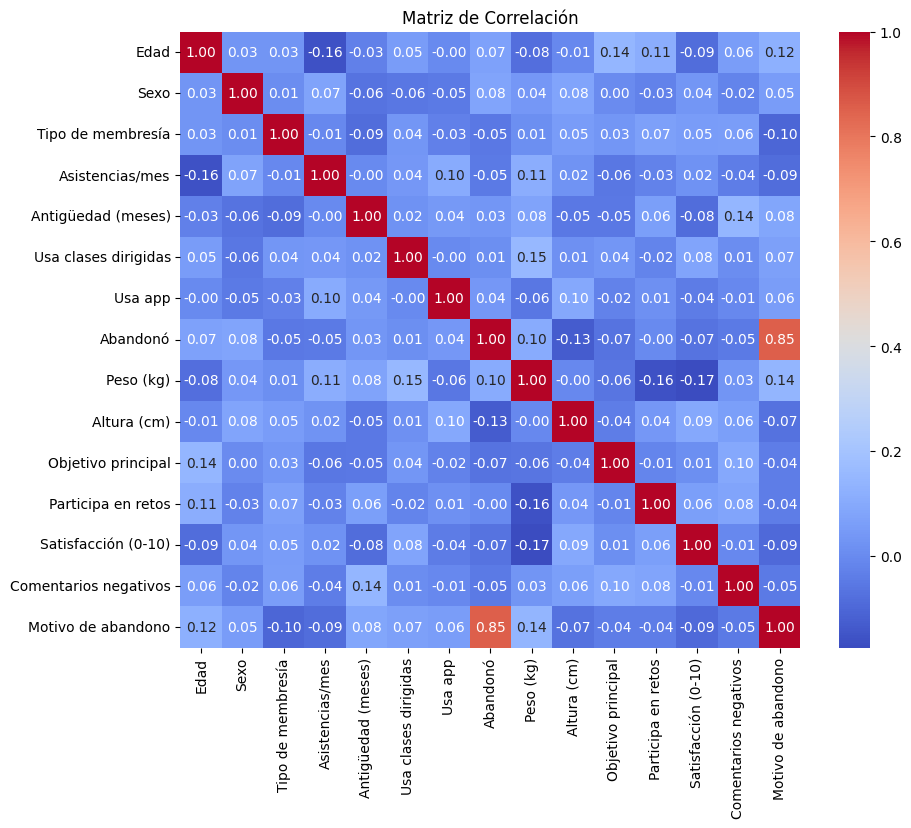

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Vemos que la única correlación que hay es la columns `Abandonó` y `Motivo de abandono` por razones obvias. Más allá de eso no hay relaciones entre el resto de características.

### Outliers e Inliers
Lo siguiente será ver si en nuestros datos tenemos **outliers** o **inliers**. En clase ya se encontraron algunos de ellos pero lo correcto sería buscarlos con un método, como Jackknife.

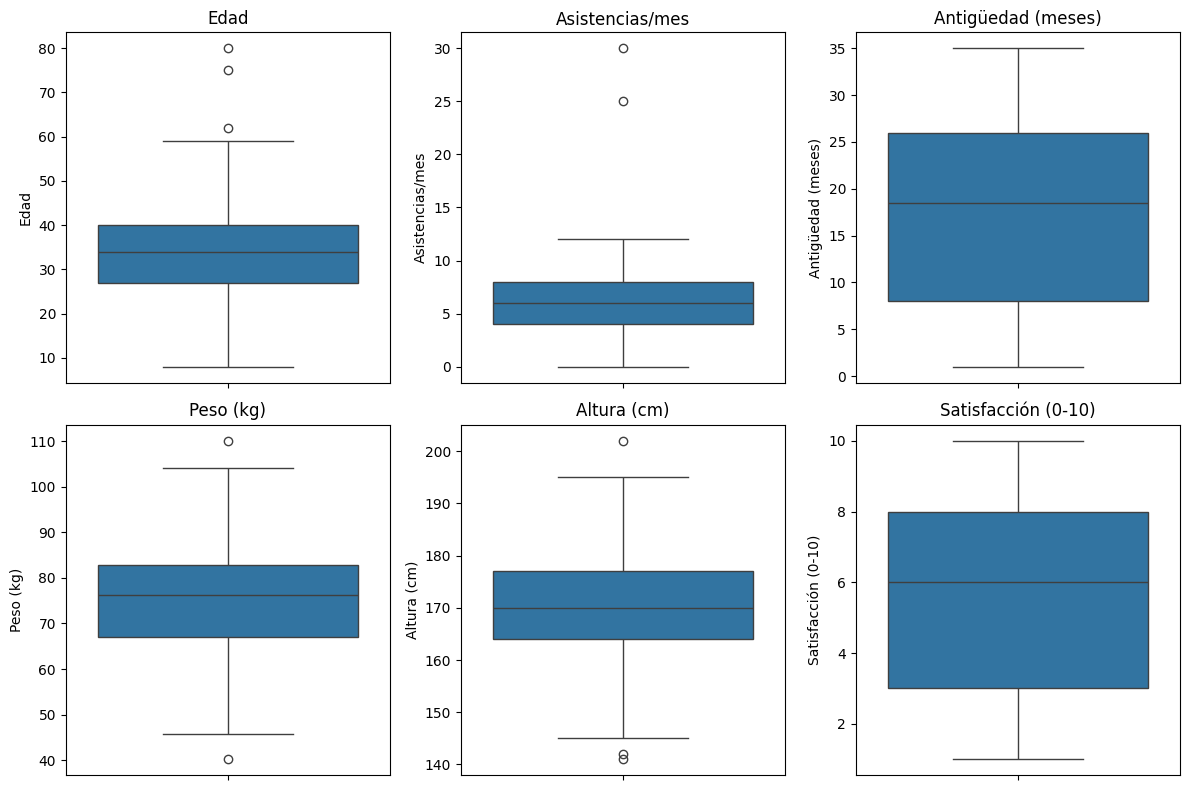

In [ ]:
# Calculate IQR for each numerical column
K = 1.5
numerical_cols = ['Edad', 'Asistencias/mes', 'Antigüedad (meses)', 'Peso (kg)', 'Altura (cm)', 'Satisfacción (0-10)']
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - K * IQR
    upper_bound = Q3 + K * IQR

    # Identify outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    # print(f"Outliers in '{col}':")
    # print(outliers[[col]])
    # print("-" * 20)



# Calculate the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = (num_cols + 2) // 3  # Calculate rows, ensuring at least 3 columns per row

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)  # Adjust subplot grid
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()


Parece que hemos conseguido identificar **algunos** outliers:

* Edad: 3 outliers
* Asistencias/mes: 2 outliers
* Peso: 2 outliers
* Altura: 3 outliers

Un total de 10 outliers **detectados éxitosamente**. Tenemos que recordar que un outlier no es lo mismo que un **valor influyente**. Un **valor influyente** es aquel outlier que **SÍ** afecta al modelo de IA.

Tenemos diferentes formas de tratar los outliers:

* Borrarlos
* Imputarlos
* Usar otros métodos más sofisticados

***IMPORTANTE: Debatir en clase si se puede esacalar los datos, de ser así se puede usar `StandardScaler` que es resistente contra los outliers.***

Si **NO** se usa escalado, se pueden intentar corregir ya que eliminar datos nos llevan a una pérdida de información.

### ¿Cómo abordar de manera inteligente los outliers?

Como hemos indicado anteriormente, podemos corregir los outliers de dos formas:

* Imputación con **valores prototípicos**.
* Realizar un **análisis más sofisticado**.

El primer método consiste en usar **valores prototípicos** como la media, mediana o moda. Y otra forma es hacer un análisis más profundo para encontrar patrones que nos ayuden a corregir estos outliers.

Por ejemplo: En los datos del Titanic se detectó que existe una relación entre la edad y la clase en la que viajaban los pasajeros de la siguiente forma:

* Edad > 30 ⟹ Primera clase
* 30 > Edad > 20 ⟹ Segunda clase
* Edad < 20 ⟹ Tercera clase

Lo mismo podemos intentar pensar en este caso, buscar que características pueden estar relacionadas y en base a eso arreglar nuestros outliers.

Para ello podemos usar algunas propuestas de los compañeros.

*Carlos Carrasquer: Realizar rangos de edades en vez de usar los datos numéricos cómo tal.*

Exacto, podemos crear rangos para poder saber donde es probable que X dato tenga este valor u otro en base al rango que pertenece. En este caso podemos hacer un rango de las alturas y representar cajas para ver donde se posicionan las edades. Para mantener que nuestro dataset siga siendo numérico podemos hacer lo siguiente:

* Baja altura ⟹ 0
* Media altura ⟹ 1
* Alta altura ⟹ 2

In [ ]:
bins = [data['Altura (cm)'].min(), 170, 180, data['Altura (cm)'].max() + 0.001]
labels = [0, 1, 2]

data['Rango de Altura'] = pd.cut(data['Altura (cm)'], bins=bins, labels=labels, right=False, include_lowest=True)

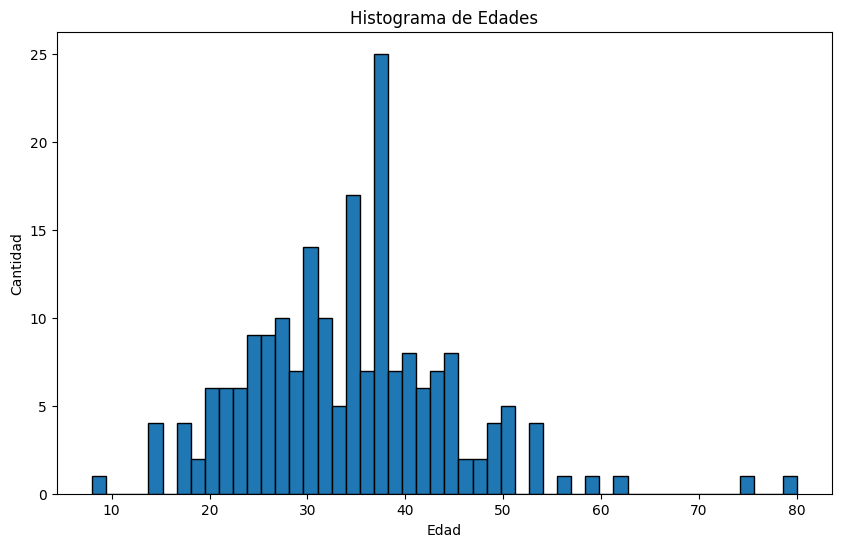

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['Edad'], bins=50, edgecolor='black')  # Adjust 'bins' as needed
plt.xlabel('Edad')
plt.ylabel('Cantidad')
plt.title('Histograma de Edades')
plt.show()


Ahora haremos nuestro gráfico de cajas en base a la Edad y la Altura.

<Axes: xlabel='Rango de Altura', ylabel='Edad'>

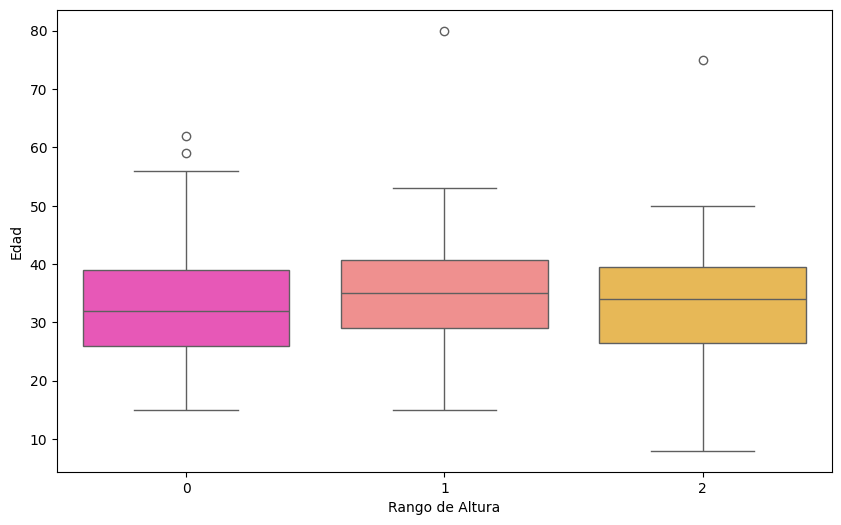

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rango de Altura',y='Edad',data=data,hue='Rango de Altura',palette='spring',legend=False)

Vemos que con esta gráfica se han detectado nuevos outliers que no aparecieron antes. Además que obtenemos la siguiente información:

* La altura baja ⟹ Tiene una mediana de 32 años.
* La altura media ⟹ Tiene una mediana de 35 años.
* La altura alta ⟹ Tiene una mediana de 32 años.

Con esto, podemos corregir la edad de la siguiente forma:

In [ ]:
# Paso 1: Define los límites manualmente (basado en lo que viste en el boxplot)
# Estos son ejemplos. Ajústalos con los valores reales de tu gráfico.
limites = {
    0: {'min': 15, 'max': 55, 'mediana': 32},
    1: {'min': 15, 'max': 53, 'mediana': 35},
    2: {'min': 17, 'max': 50, 'mediana': 32}
}

# Paso 2: Función para imputar si está fuera de los bigotes
def imputar_outlier(row):
    rango = row['Rango de Altura']
    edad = row['Edad']
    limite = limites[rango]

    if edad < limite['min'] or edad > limite['max']:
        return limite['mediana']
    return edad

# Paso 3: Aplicar la función al DataFrame
data['Edad'] = data.apply(imputar_outlier, axis=1)

<Axes: xlabel='Rango de Altura', ylabel='Edad'>

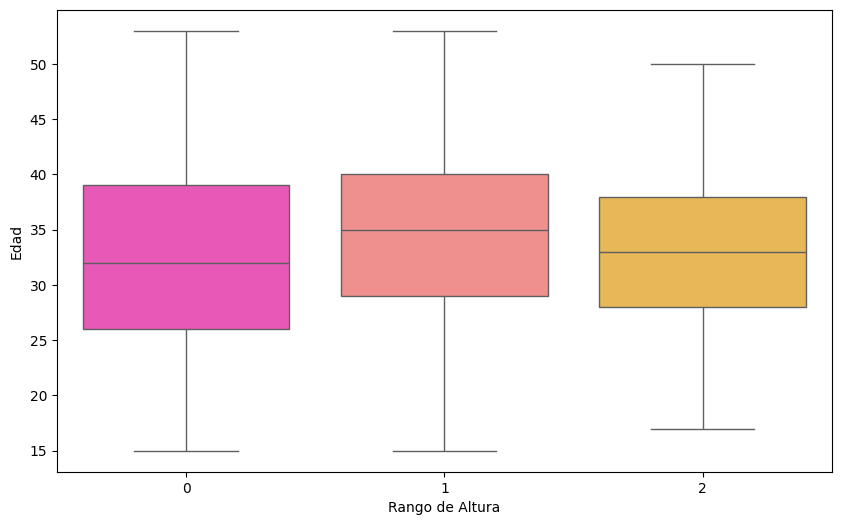

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rango de Altura',y='Edad',data=data,hue='Rango de Altura',palette='spring',legend=False)

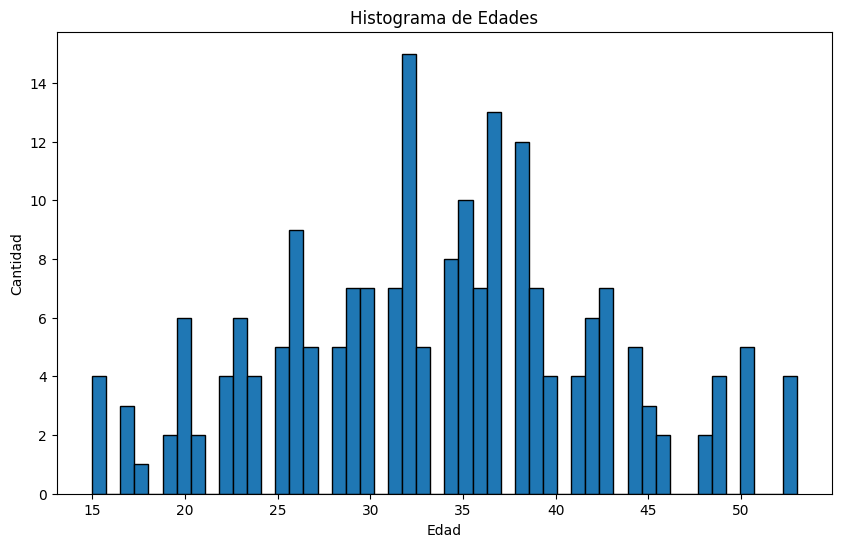

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['Edad'], bins=50, edgecolor='black')  # Adjust 'bins' as needed
plt.xlabel('Edad')
plt.ylabel('Cantidad')
plt.title('Histograma de Edades')
plt.show()

De esta forma podemos solucionar manualmente los outliers presentes. Habría que buscar otras relaciones que nos pudieran dar más outliers.

***Plantear otras relaciones en clase.***

## Transformación
---
### Combinar columnas

Combinar las columnas uso de la app, uso de clases dirigidas y participación en retos para comprobar si el usuario tiene interés en  el uso de recursos del gimnasio es más o menos probable que abandone.


In [ ]:
# Crear una nueva columna que combine las tres columnas
data['Interes_recursos'] = data['Usa app'] + data['Usa clases dirigidas'] + data['Participa en retos']

# Mostrar las primeras filas del DataFrame actualizado
data.head()

,Edad,Sexo,Tipo de membresía,Asistencias/mes,Antigüedad (meses),Usa clases dirigidas,Usa app,Abandonó,Peso (kg),Altura (cm),Objetivo principal,Participa en retos,Satisfacción (0-10),Comentarios negativos,Motivo de abandono,Rango de Altura,Interes_recursos
0,39.0,1,2,8,28,0,1,1,85.1,155,0,0,1,1,1,0,1
1,33.0,1,0,25,11,1,1,0,98.8,180,0,0,7,0,0,2,2
2,41.0,0,2,4,33,1,1,0,66.9,170,2,0,2,0,0,1,2
3,50.0,1,2,3,17,0,0,0,82.6,183,3,0,2,1,0,2,0
4,32.0,0,0,6,6,1,1,0,84.2,167,1,1,5,1,0,0,3


Como las columnas son númericas, hay que indicar el contexto de lo que se está mostrando. La columna `Interes_recursos` muestra lo siguiente:

* 0 ⟹ No se usaron recursos
* 1 ⟹ Se usó 1 recurso
* 2 ⟹ Se usaron 2 recursos
* 3 ⟹ Se usaron todos los recursos

Hacemos una tabla de contigencia para analizar la relación entre el uso de recursos y el abandono.

In [ ]:
# Analizar la relación entre 'Interes_recursos' y 'Abandonó'
# (Ejemplo: usando una tabla de contingencia o un gráfico)
contingency_table = pd.crosstab(data['Interes_recursos'], data['Abandonó'])
print(contingency_table)

Abandonó           0   1
Interes_recursos        
0                  8   3
1                 54  19
2                 50  28
3                 28  10


<Figure size 800x600 with 0 Axes>

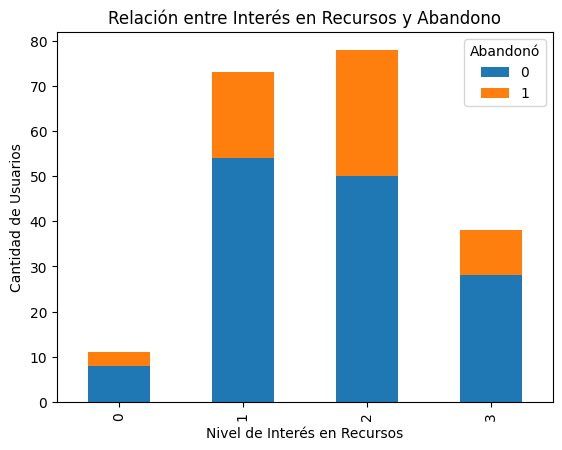

In [ ]:
# Visualizar la relación con un gráfico de barras
plt.figure(figsize=(8, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.title('Relación entre Interés en Recursos y Abandono')
plt.xlabel('Nivel de Interés en Recursos')
plt.ylabel('Cantidad de Usuarios')
plt.show()

Podemos observar que la cantidad de clientes que abandonan el gimnasio es más probable que hayan usado al menos un recurso del gimnasio, el problema es que no se sabe que recurso han usado. Podemos hacer un estudio por cada recurso para ver el impacto de cada recurso.

In [ ]:
app_table = pd.crosstab(data['Usa app'], data['Abandonó'])
clase_table = pd.crosstab(data['Usa clases dirigidas'], data['Abandonó'])
retos_table = pd.crosstab(data['Participa en retos'], data['Abandonó'])

print(app_table)
print("="*35)
print(clase_table)
print("="*35)
print(retos_table)

Abandonó   0   1
Usa app         
0         43  16
1         97  44
Abandonó               0   1
Usa clases dirigidas        
0                     60  25
1                     80  35
Abandonó             0   1
Participa en retos        
0                   79  34
1                   61  26


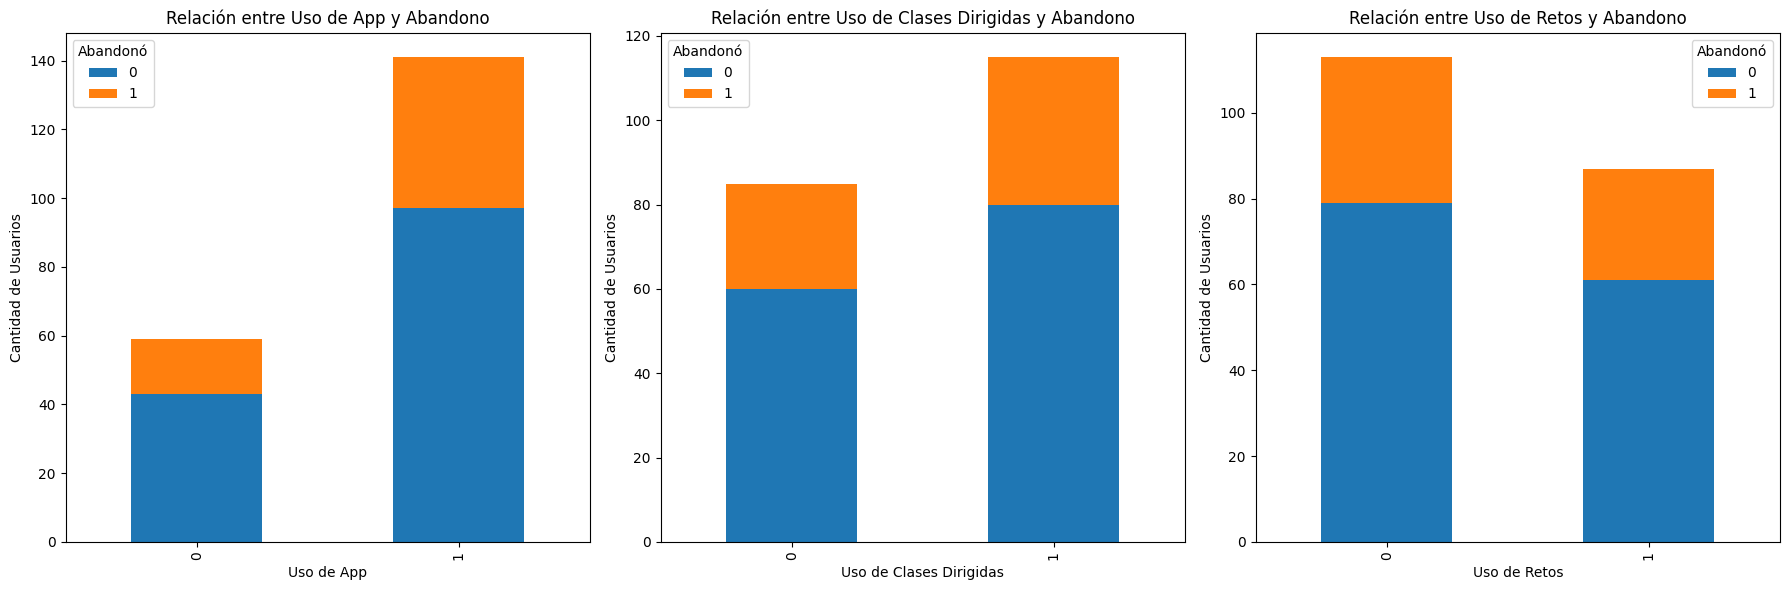

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Aumenta tamaño para mejor visibilidad

# Subgráfico 1
app_table.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Relación entre Uso de App y Abandono')
axes[0].set_xlabel('Uso de App')
axes[0].set_ylabel('Cantidad de Usuarios')

# Subgráfico 2
clase_table.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Relación entre Uso de Clases Dirigidas y Abandono')
axes[1].set_xlabel('Uso de Clases Dirigidas')
axes[1].set_ylabel('Cantidad de Usuarios')

# Subgráfico 3
retos_table.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title('Relación entre Uso de Retos y Abandono')
axes[2].set_xlabel('Uso de Retos')
axes[2].set_ylabel('Cantidad de Usuarios')

plt.tight_layout()
plt.show()

Vemos que de los tres recursos, los que tienen un mayor número de gente que ha abandonado son la App y las clases dirigidas. Aquí hay algunas hipótesis que nos pueden hacer pensar el por qué ocurre esto:

* La relación del uso de la App puede ser por la oferta especial.
* La relación de las clases dirigidas puede ser por los comentarios negativos.

# Minería de datos
---

### Arboles de Decision

Hemos decidido usar un árbol de decisión.

In [ ]:
TEST_SIZE=0.2
RANDOM_STATE=42
MAX_DEPTH=2
MIN_SAMPLES_SPLIT=4
MIN_SAMPLES_LEAF=3
CV=5
N_ITER=10

In [41]:
X = data.drop('Abandonó', axis=1)
y = data['Abandonó']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [42]:
train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = train[train['Abandonó'] == 0]
df_minority = train[train['Abandonó'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,  # Sample without replacement
                                 n_samples=len(df_minority),  # Match minority class size
                                 random_state=42)  # Set random state for reproducibility

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled['Abandonó'].value_counts())


Abandonó
0    47
1    47
Name: count, dtype: int64


In [43]:
# Now use df_downsampled for your train/test split and model training.
# Example:
X_train = df_downsampled.drop('Abandonó', axis=1)
y_train = df_downsampled['Abandonó']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [44]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=N_ITER,  # Number of parameter settings that are sampled
    cv=CV,  # Number of cross-validation folds
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=RANDOM_STATE
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train2, y_train2)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters:", random_search.best_params_)
print("Best accuracy score:", random_search.best_score_)

# Evaluate the model with the best hyperparameters on the test set
best_rf_classifier = random_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set with best hyperparameters: {accuracy}")
print(classification_report(y_test, y_pred))


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best accuracy score: 1.0
Accuracy on the test set with best hyperparameters: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        13

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



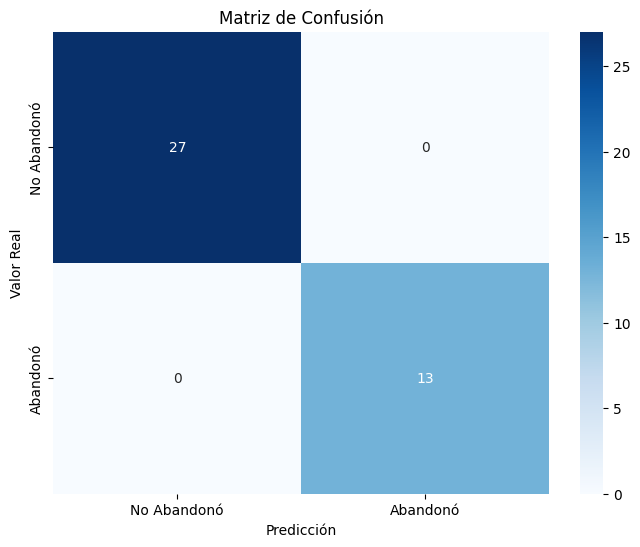

In [45]:
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Abandonó', 'Abandonó'],
            yticklabels=['No Abandonó', 'Abandonó'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


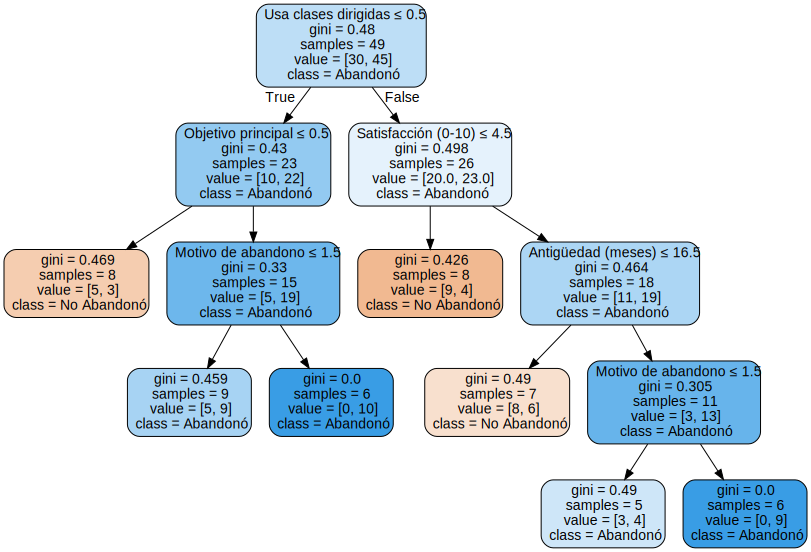

In [46]:
# Extract the first decision tree
estimator = best_rf_classifier.estimators_[0]


# Export the decision tree to a DOT file
dot_data = export_graphviz(estimator,
                           out_file=None,
                           feature_names=X.columns,  # Use your feature names
                           class_names=['No Abandonó', 'Abandonó'], # Use your class names
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Create a graphviz object from the DOT data
graph = graphviz.Source(dot_data)

# Display the decision tree
graph
